# Quasi-Monte Carlo Generators, Randomizers, and Fast Transforms

## Setup

In [1]:
import qmcpy as qp
import numpy as np
import timeit
from collections import OrderedDict
import os
import scipy.stats
import time
import torch
import sympy
import gc
import itertools

In [2]:
import matplotlib 
from matplotlib import pyplot
from tueplots import cycler
from tueplots.bundles import probnum2025
from tueplots.constants import markers
from tueplots.constants.color import palettes
matplotlib.rcParams['figure.dpi'] = 256
_golden = (1 + 5 ** 0.5) / 2
MW1 = 240/72
MW2 = 500/72
MH1 = MW1/_golden
MH2 = MW2/_golden
COLORS = palettes.tue_plot
MARKERS = markers.o_sized
pyplot.rcParams.update(probnum2025())
pyplot.rcParams.update(cycler.cycler(color=COLORS,marker=MARKERS))

## Snippets

### Point Sets

In [3]:
%%time 
lattice = qp.Lattice(
    dimension = 52,
    randomize = "shift", # for unrandomized lattice set randomize = None
    replications = 16, # R
    order = "radical inverse", # also supports "linear" and "Gray code"
    seed = None, # pass integer seed for reproducibility
    generating_vector = "LDData:mps.exod2_base2_m20_CKN.txt")
x = lattice(2**16) # a numpy.ndarray with shape 16 x 65536 x 52

CPU times: user 1.02 s, sys: 121 ms, total: 1.14 s
Wall time: 1.98 s


In [4]:
%%time
dnb2 = qp.DigitalNetB2(
    dimension = 52, 
    randomize = "LMS DS", # Matousek's LMS then a digital shift
    # other options ["NUS", "DS", "LMS", None]
    t = 64, # number of LMS bits i.e. number of rows in S_j
    alpha = 2, # interlacing factor for higher order digital nets
    replications = 16, # R
    order = "radical inverse", # also supports "Gray code"
    seed = None, # pass integer seed for reproducibility
    generating_matrices = "LDData:mps.sobol_Cs.txt")
x = dnb2(2**16) # a numpy.ndarray with shape 16 x 65536 x 52

CPU times: user 1.1 s, sys: 434 ms, total: 1.53 s
Wall time: 2.07 s


In [ ]:
%%time 
halton = qp.Halton(
    dimension = 52, 
    randomize = "LMS DP", # Matousek's LMS then a digital permutation
    # other options ["LMS DS", "LMS", "DP", "DS", "NUS", "QRNG", None]
    t = 64, # number of LMS digits i.e. number of rows in S_j
    replications = 16, # R
    seed = None) # pass integer seed for reproducibility
x = halton(2**10) # a numpy.ndarray with shape 16 x 1024 x 52

CPU times: user 1.45 s, sys: 376 ms, total: 1.83 s
Wall time: 1.97 s


### Kernel Methods

#### Lattice + FFTBR + IFFTBR

In [6]:
m = 10 # will generate 2^m points
n = 2**m # number of points
rng = np.random.Generator(np.random.PCG64()) # used to generate random y
lattice = qp.Lattice(dimension=3)
x1 = lattice(n_min=0,n_max=n) # shape=(n,3) lattice points
y1 = rng.uniform(low=0,high=1,size=n) # shape=(n,) random uniforms
alpha = [2, 2, 2] # smoothness parameters
gamma = [1, 1/2, 1/4] # product weights
# slow matrix multiplication and linear system solve 
kmat1 = qp.kernel_si(x1[:,None],x1[None,:],alpha,gamma) # shape=(n,n)
z1_slow = kmat1@y1 # matrix multiplication
v1_slow = np.linalg.solve(kmat1,y1) # solve a linear system
# fast matrix multiplication and linear system solve
k1 = qp.kernel_si(x1,x1[0],alpha,gamma) # shape=(n,)
assert (k1==kmat1[:,0]).all() # k1 is the first column of kmat1
lam1 = np.sqrt(n)*qp.fftbr(k1) # shape=(n,) vector of eigenvalues 
y1t = qp.fftbr(y1)
z1_fast = qp.ifftbr(y1t*lam1) # fast matrix multiplication 
v1_fast = qp.ifftbr(y1t/lam1) # fast linear system solve
# verify correctness
assert np.allclose(z1_fast,z1_slow)
assert np.allclose(v1_fast,v1_slow)

In [7]:
y2 = rng.uniform(low=0,high=1,size=n)
# inefficient fast transform update 
yfull = np.concatenate([y1,y2]) # shape=(2*n,)
yt_inefficient = qp.fftbr(yfull)
# efficient fast transform update 
y2t = qp.fftbr(y2) # shape=(n,)
omega = qp.omega_fftbr(m) # shape=(n,) 
yt_efficient = np.hstack([y1t+omega*y2t,y1t-omega*y2t])/np.sqrt(2)
# verify correctness
assert np.allclose(yt_efficient,yt_inefficient)

#### Digital Net + FWHT

In [8]:
m = 10 # will generate 2^m points
n = 2**m # number of points
rng = np.random.Generator(np.random.PCG64()) # used to generate random y
dnb2 = qp.DigitalNetB2(dimension=3)
t = dnb2.t # number of bits in integer representations of points
x1 = dnb2(n_min=0,n_max=n,return_binary=True) # shape=(n,3) digital net
y1 = rng.uniform(low=0,high=1,size=n) # shape=(n,) random uniforms
alpha = [2, 2, 2] # smoothness parameters
gamma = [1, 1/2, 1/4] # product weights
# slow matrix multiplication and linear system solve 
kmat1 = qp.kernel_dsi(x1[:,None],x1[None,:],t,alpha,gamma) # shape=(n,n)
z1_slow = kmat1@y1 # matrix multiplication
v1_slow = np.linalg.solve(kmat1,y1) # solve a linear system
# fast matrix multiplication and linear system solve
k1 = qp.kernel_dsi(x1,x1[0],t,alpha,gamma) # shape=(n,)
assert (k1==kmat1[:,0]).all() # k1 is the first column of kmat1
lam1 = np.sqrt(n)*qp.fwht(k1) # shape=(n,) vector of eigenvalues 
y1t = qp.fwht(y1)
z1_fast = qp.fwht(y1t*lam1) # fast matrix multiplication 
v1_fast = qp.fwht(y1t/lam1) # fast linear system solve
# verify correctness
assert np.allclose(z1_fast,z1_slow)
assert np.allclose(v1_fast,v1_slow)

In [9]:
y2 = rng.uniform(low=0,high=1,size=n)
# inefficient fast transform update 
yfull = np.concatenate([y1,y2]) # shape=(2*n,)
yt_inefficient = qp.fwht(yfull)
# efficient fast transform update 
y2t = qp.fwht(y2) # shape=(n,)
omega = qp.omega_fwht(m) # shape=(n,) 
yt_efficient = np.hstack([y1t+omega*y2t,y1t-omega*y2t])/np.sqrt(2)
# verify correctness
assert np.allclose(yt_efficient,yt_inefficient)

### Integration

In [10]:
import scipy.stats
def gen_corner_peak_2(x):
    d = x.shape[-1] # x.shape=(...,n,d), e.g., (n,d) or (r,n,d) 
    c_tilde = 1/np.arange(1,d+1)**2
    c = 0.25*c_tilde/np.sum(c_tilde)
    y = (1+np.sum(c*x,axis=-1))**(-(d+1)) 
    return y # y.shape=(...,n), e.g., (n,) or (r,n)
r = 10 # number of randomizations
n = 2**15 # number of points 
d = 50 # dimension
dnb2 = qp.DigitalNet(dimension=d, replications=r, seed=7, alpha=3)
x = dnb2(n) # x.shape=(r,n,d)
y = gen_corner_peak_2(x) # y.shape=(r,n) 
muhats = np.mean(y,axis=1) # muhats.shape=(r,)
muhat_aggregate = np.mean(muhats) # muhat_aggregate is a scalar 
print(muhat_aggregate)
alpha = 0.01 # uncertainty level
t_star = -scipy.stats.t.ppf(alpha/2,df=r-1) # quantile of Student's t 
stdhat = np.std(muhats,ddof=1) # unbiased estimate of standard deviation
std_error = t_star*stdhat/np.sqrt(r)
print(std_error)
conf_int = [muhat_aggregate-std_error,muhat_aggregate+std_error]

0.014936813948394042
5.247445301861484e-07


In [11]:
def gen_corner_peak_2(x):
    d = x.shape[-1] # x.shape=(...,n,d), e.g., (n,d) or (r,n,d) 
    c_tilde = 1/np.arange(1,d+1)**2
    c = 0.25*c_tilde/np.sum(c_tilde)
    y = (1+np.sum(c*x,axis=-1))**(-(d+1)) 
    return y # y.shape=(...,n), e.g., (n,) or (r,n)
r = 10
d = 50 
dnb2 = qp.DigitalNet(dimension=d, replications=r, seed=7, alpha=3)
true_measure = qp.Uniform(dnb2, lower_bound=0, upper_bound=1)
integrand = qp.CustomFun(true_measure=true_measure, g=gen_corner_peak_2)
# equivalent to 
# integrand = qp.Genz(dnb2, kind_func="CORNER PEAK", kind_coeff=2)
qmc_algo = qp.CubQMCRepStudentT(integrand, abs_tol=1e-4)
solution,data = qmc_algo.integrate() # run adaptive QMC algorithm 
print(solution)
conf_int = [data.comb_bound_low,data.comb_bound_high]
std_error = (conf_int[1]-conf_int[0])/2
print(std_error)
print(data)

0.014950908095474802
2.7968149935497788e-05
Data (Data)
    solution        0.015
    comb_bound_low  0.015
    comb_bound_high 0.015
    comb_bound_diff 5.59e-05
    comb_flags      1
    n_total         10240
    n               10240
    n_rep           2^(10)
    time_integrate  0.019
CubQMCRepStudentT (AbstractStoppingCriterion)
    inflate         1
    alpha           0.010
    abs_tol         1.00e-04
    rel_tol         0
    n_init          2^(8)
    n_limit         2^(30)
CustomFun (AbstractIntegrand)
Uniform (AbstractTrueMeasure)
    lower_bound     0
    upper_bound     1
DigitalNetB2 (AbstractLDDiscreteDistribution)
    d               50
    replications    10
    randomize       LMS DS
    gen_mats_source joe_kuo.6.21201.txt
    order           RADICAL INVERSE
    t               63
    alpha           3
    n_limit         2^(32)
    entropy         7


## Pointsets

In [89]:
m = 13 # n = 2^m
n = 2**m # number of points
d = 2 # dimensions

In [121]:
pointsets = OrderedDict({
    "IID": (qp.IIDStdUniform(d).gen_samples(n),{"color":COLORS[2]}),
    "Lattice Shift": (qp.Lattice(d).gen_samples(n),{"color":COLORS[5]}),
    "Halton LMS DP": (qp.Halton(d,randomize="LMS_PERM").gen_samples(n),{"color":COLORS[1]}),
    "Halton NUS": (qp.Halton(d,randomize="NUS").gen_samples(n),{"color":COLORS[4]}),
    r"DN${}_{1}$ LMS DS": (qp.DigitalNetB2(d,randomize="LMS_DS").gen_samples(n),{"color":COLORS[0]}),
    r"DN${}_{2}$ LMS DS": (qp.DigitalNetB2(d,randomize="LMS_DS",alpha=2).gen_samples(n),{"color":COLORS[0]}),
    r"DN${}_{3}$ LMS DS": (qp.DigitalNetB2(d,randomize="LMS_DS",alpha=3).gen_samples(n),{"color":COLORS[0]}),
    r"DN${}_{4}$ LMS DS": (qp.DigitalNetB2(d,randomize="LMS_DS",alpha=4).gen_samples(n),{"color":COLORS[0]}),
    r"DN${}_{1}$ NUS": (qp.DigitalNetB2(d,randomize="NUS").gen_samples(n),{"color":COLORS[3]}),
    r"DN${}_{2}$ NUS": (qp.DigitalNetB2(d,randomize="NUS",alpha=2).gen_samples(n),{"color":COLORS[3]}),
    r"DN${}_{3}$ NUS": (qp.DigitalNetB2(d,randomize="NUS",alpha=3).gen_samples(n),{"color":COLORS[3]}),
    r"DN${}_{4}$ NUS": (qp.DigitalNetB2(d,randomize="NUS",alpha=4).gen_samples(n),{"color":COLORS[3]}),
})

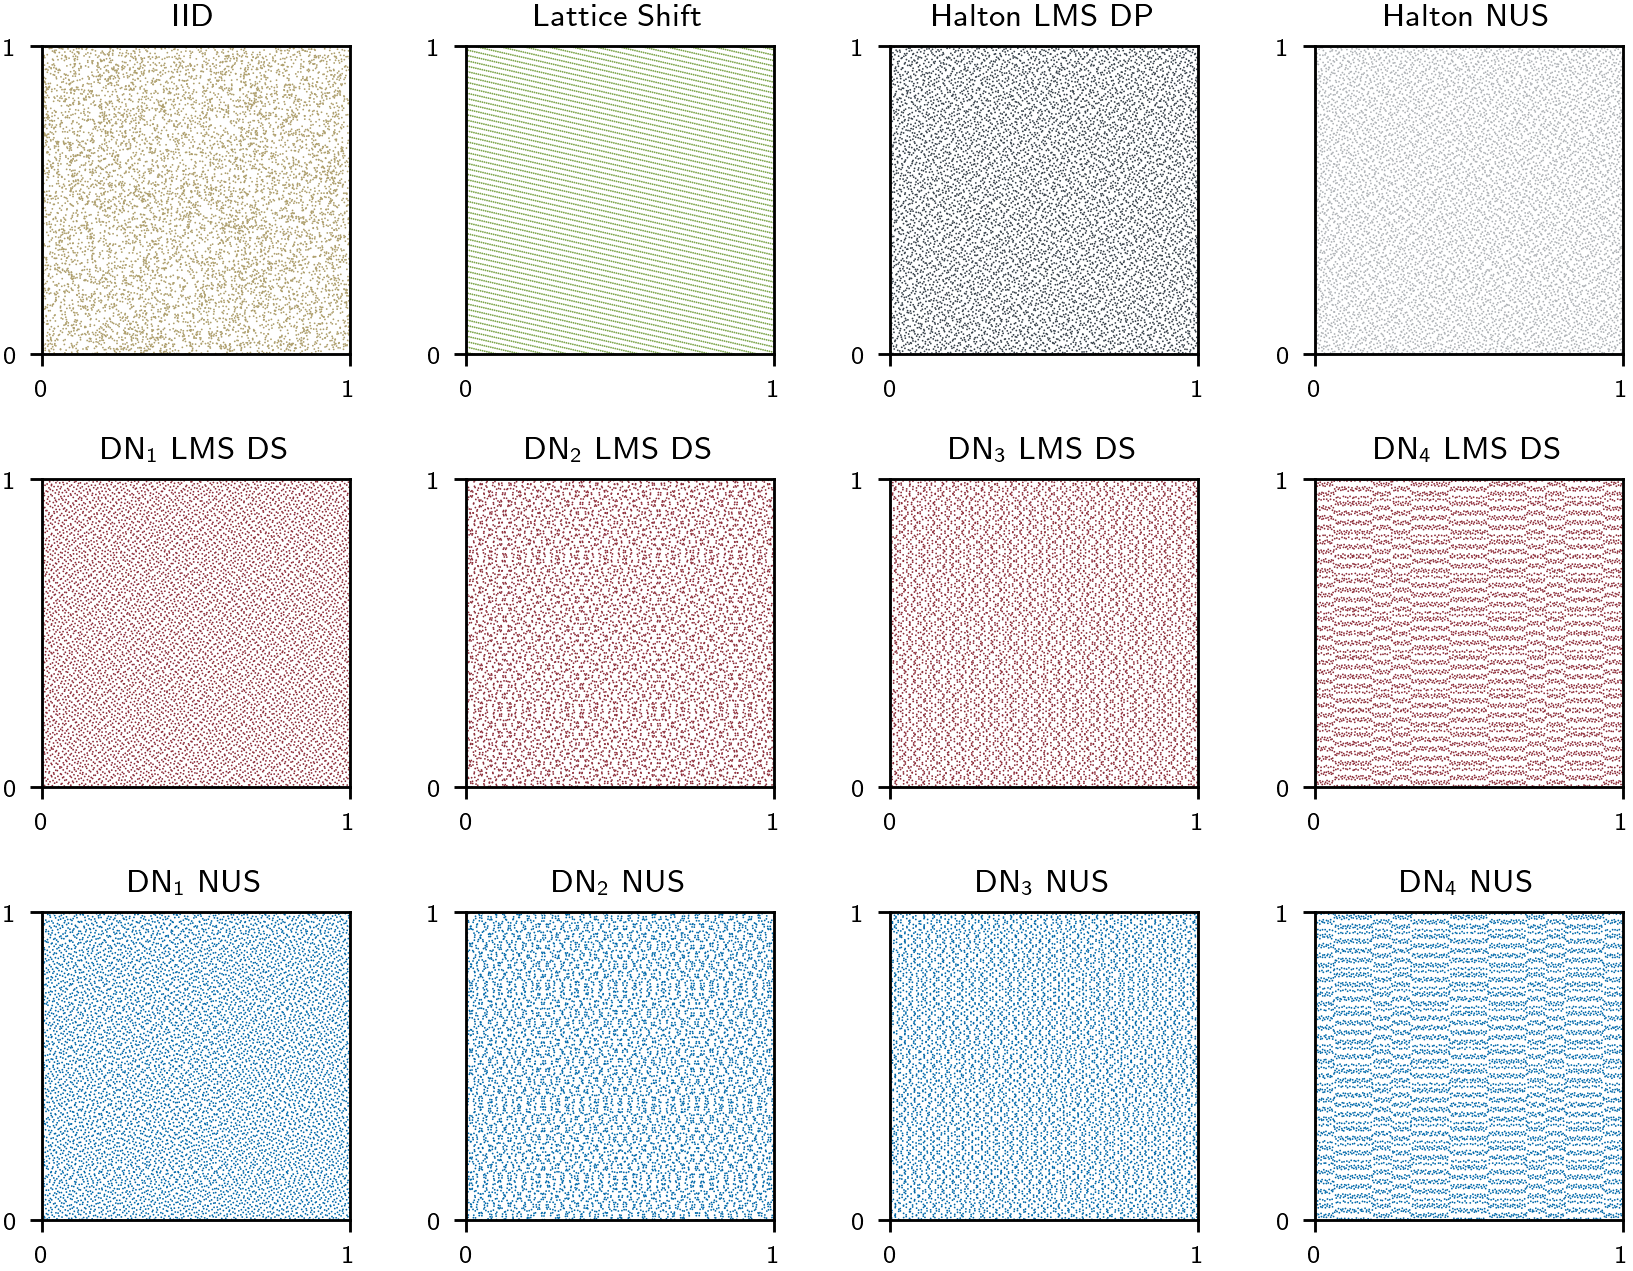

In [124]:
nrows,ncols = 3,4
assert len(pointsets)==(nrows*ncols)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(MW2,MW2/ncols*nrows),constrained_layout=False,tight_layout=False)#figsize=(ncols*3,nrows*3))
s = .25
for i,(name,(x,pltkwargs)) in enumerate(pointsets.items()):
    ri,ci = i//ncols,i%ncols
    ax[ri,ci].set_title(name)
    ax[ri,ci].scatter(x[:,0],x[:,1],s=s,marker='o',edgecolor='none',**pltkwargs)#,fillstyle='full')
    ax[ri,ci].set_xlim([0,1]); ax[ri,ci].set_xticks([0,1])
    ax[ri,ci].set_ylim([0,1]); ax[ri,ci].set_yticks([0,1])
    ax[ri,ci].set_aspect(1)
fig.savefig("outputs/pointsets.png",format="png",dpi=1024,transparent=True)

## Generation time

In [3]:
reps = 5
m_max = 20

In [ ]:
def time_block(pointsets_fns, rds):
    data = {}
    for name,(generator,pltkwargs) in pointsets_fns.items():
        data[name] = np.nan*np.empty((len(rds),m_max+1,reps),dtype=np.float64)
        for i,(r,d) in enumerate(rds):
            print("%25s (r=%4d, d=%4d): "%(name,r,d),end="",flush=True)
            for m in range(0,m_max+1):
                print("%d, "%m,end='',flush=True)
                for t in range(reps):
                    gc.collect()
                    t0 = time.process_time()
                    x = generator(r,2**m,d)
                    data[name][i,m,t] = time.process_time()-t0
                    del x
                if np.mean(data[name][i,m])>=.2: break
            print()
        print()
    return data 

In [6]:
pointsets_noho_fns = OrderedDict({
    r"DN${}_{1}$ LMS DS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r).gen_samples(n),{"color":COLORS[0],"marker":MARKERS[0]}),
    "Halton LMS DP": (lambda r,n,d: qp.Halton(d,randomize="LMS_DS",replications=r).gen_samples(n),{"color":COLORS[1],"marker":MARKERS[1]}),
    "IID": (lambda r,n,d: qp.IIDStdUniform(d,replications=r).gen_samples(n),{"color":COLORS[2],"marker":MARKERS[2]}),
    r"DN${}_{1}$ NUS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="NUS",replications=r).gen_samples(n),{"color":COLORS[3],"marker":MARKERS[3]}),
    "Halton NUS": (lambda r,n,d: qp.Halton(d,randomize="NUS",replications=r).gen_samples(n),{"color":COLORS[4],"marker":MARKERS[4]}),
    "Lattice Shift": (lambda r,n,d: qp.Lattice(d,replications=r).gen_samples(n),{"color":COLORS[5],"marker":MARKERS[5]}),
    r"SciPy DN${}_{1}$ LMS DS": (lambda r,n,d: np.stack([scipy.stats.qmc.Sobol(d=d,scramble=True,bits=63).random(n) for i in range(r)],axis=0),{"color":COLORS[6],"marker":MARKERS[6]}),
    "Halton DP": (lambda r,n,d: qp.Halton(d,randomize="DP",replications=r).gen_samples(n),{"color":COLORS[7],"marker":MARKERS[7]}),
    r"PyTorch DN${}_{1}$ LMS DS": (lambda r,n,d: np.stack([torch.quasirandom.SobolEngine(d,scramble=True).draw(n) for i in range(r)],axis=0),{"color":COLORS[8],"marker":MARKERS[8]}),
    "SciPy Halton DP": (lambda r,n,d: np.stack([scipy.stats.qmc.Halton(d=d,scramble=True).random(n) for i in range(r)],axis=0),{"color":COLORS[9],"marker":MARKERS[9]}),
})
rds_noho = np.array([
    [1,1],
    [1,100],
    [100,1],
    [10,10],
])
t_noho = time_block(pointsets_noho_fns,rds_noho) 

        DN${}_{1}$ LMS DS (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
        DN${}_{1}$ LMS DS (r=1, d=100): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
        DN${}_{1}$ LMS DS (r=100, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
        DN${}_{1}$ LMS DS (r=10, d=10): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 

            Halton LMS DP (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
            Halton LMS DP (r=1, d=100): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
            Halton LMS DP (r=100, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
            Halton LMS DP (r=10, d=10): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 

                      IID (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                      IID (r=1, d=100): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
      

In [7]:
pointsets_dnb2_lms_ds_nus_ho_fns = OrderedDict({
    r"DN${}_{1}$ LMS DS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=1).gen_samples(n),{"color":COLORS[0],"marker":MARKERS[0]}),
    r"DN${}_{1}$ NUS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=1).gen_samples(n),{"color":COLORS[3],"marker":MARKERS[3]}),
    r"DN${}_{2}$ LMS DS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=2).gen_samples(n),{"color":COLORS[0],"marker":MARKERS[1]}),
    r"DN${}_{2}$ NUS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=2).gen_samples(n),{"color":COLORS[3],"marker":MARKERS[4]}),
    r"DN${}_{3}$ LMS DS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=3).gen_samples(n),{"color":COLORS[0],"marker":MARKERS[2]}),
    r"DN${}_{3}$ NUS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=3).gen_samples(n),{"color":COLORS[3],"marker":MARKERS[5]}),
    r"DN${}_{4}$ LMS DS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,alpha=4).gen_samples(n),{"color":COLORS[0],"marker":MARKERS[7]}),
    r"DN${}_{4}$ NUS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="NUS",replications=r,alpha=4).gen_samples(n),{"color":COLORS[3],"marker":MARKERS[6]}),
})
rds_dnb2_lms_ds_nus_ho = np.array([
    [1,1],
    [1,100],
    [100,1],
    [10,10],
])
t_dnb2_lms_ds_nus_ho = time_block(pointsets_dnb2_lms_ds_nus_ho_fns,rds_dnb2_lms_ds_nus_ho)

        DN${}_{1}$ LMS DS (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
        DN${}_{1}$ LMS DS (r=1, d=100): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
        DN${}_{1}$ LMS DS (r=100, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
        DN${}_{1}$ LMS DS (r=10, d=10): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 

           DN${}_{1}$ NUS (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 
           DN${}_{1}$ NUS (r=1, d=100): 0, 1, 2, 3, 4, 5, 6, 7, 
           DN${}_{1}$ NUS (r=100, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 
           DN${}_{1}$ NUS (r=10, d=10): 0, 1, 2, 3, 4, 5, 6, 7, 

        DN${}_{2}$ LMS DS (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
        DN${}_{2}$ LMS DS (r=1, d=100): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 
        DN${}_{2}$ LMS DS (r=100, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [10]:
rds_ft = np.array([
    [1,1],
    [10,1],
    [100,1],
    [1000,1],
])
assert (rds_ft[:,1]==1).all()
_rmax = 100
x_fft  = np.random.rand(_rmax*2**(m_max))+1j*np.random.rand(_rmax*2**(m_max))
x_fwht = np.random.rand(_rmax*2**(m_max))
ft_fns = OrderedDict({
    "FFT BR": (lambda r,n,d: qp.fftbr(x_fft[:r*n].reshape((r,n))),{"color":COLORS[0],"marker":MARKERS[0]}),
    "SciPy FFT": (lambda r,n,d: scipy.fft.fft(x_fft[:r*n].reshape((r,n))),{"color":COLORS[0],"marker":MARKERS[1]}),
    "IFFT BR": (lambda r,n,d: qp.ifftbr(x_fft[:r*n].reshape((r,n))),{"color":COLORS[1],"marker":MARKERS[2]}),
    "SciPy IFFT": (lambda r,n,d: scipy.fft.ifft(x_fft[:r*n].reshape((r,n))),{"color":COLORS[1],"marker":MARKERS[3]}),
    "FWHT": (lambda r,n,d: qp.fwht(x_fwht[:r*n].reshape((r,n))),{"color":COLORS[2],"marker":MARKERS[4]}),
    "SymPy FWHT": (lambda r,n,d: np.stack([sympy.fwht(x_fwht_i) for x_fwht_i in x_fwht[:r*n].reshape((r,n))],axis=0),{"color":COLORS[2],"marker":MARKERS[5]}),
})
t_ft = time_block(ft_fns,rds_ft)

                   FFT BR (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                   FFT BR (r=10, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                   FFT BR (r=100, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                   FFT BR (r=1000, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

                SciPy FFT (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                SciPy FFT (r=10, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                SciPy FFT (r=100, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                SciPy FFT (r=1000, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 

                  IFFT BR (r=1, d=1): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                  IFFT BR (r=10, d=1): 0, 1, 

/Users/alegresor/miniconda3/envs/qmcpy/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'tight_layout' and 'constrained_layout' cannot be used together. Please use 'layout' parameter
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))
/var/folders/rz/_ktvltjs49v_z33w0h6njx5w0000gn/T/ipykernel_57786/2672133502.py:10: RuntimeWarning: Mean of empty slice
  statfunc = lambda x: np.nanmean(x[:,1:],axis=1)


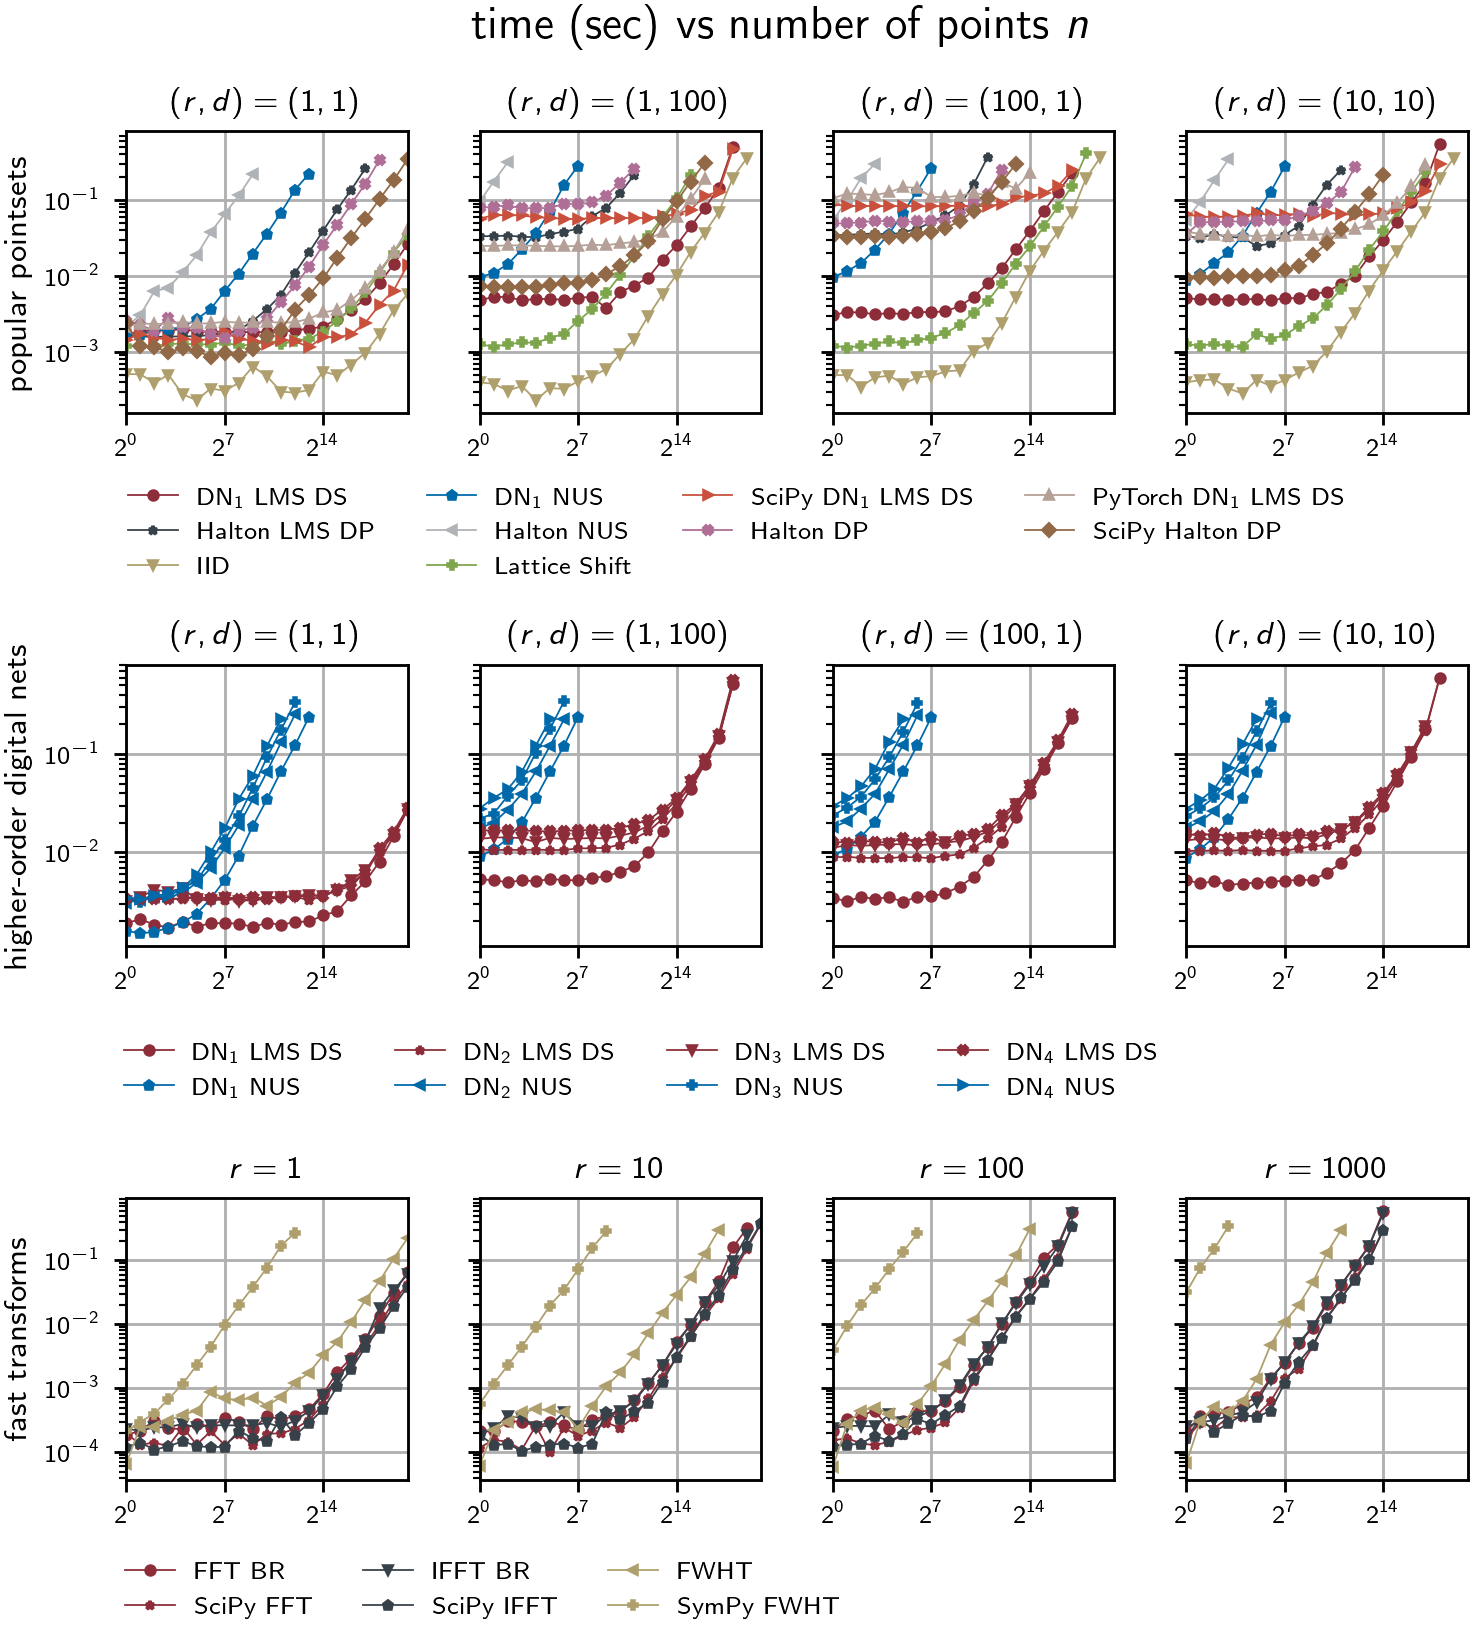

In [88]:
ncols = 4
nrows = 3
mvec = np.arange(0,m_max+1)
nvec = 2**mvec
fig = pyplot.figure(figsize=(MW2,MW2/ncols*nrows*1.2),constrained_layout=False,tight_layout=False)#,sharey=True,sharex=True)
subfigs = fig.subfigures(nrows=nrows,ncols=1)
ax = np.stack([subfigs[j].subplots(nrows=1,ncols=ncols,sharey=True,sharex=True) for j in range(nrows)],axis=0)
commonkwargs = {"markersize":2.5,"linewidth":.5}#,"markerfacecolor":'black',"markeredgecolor":'white'}
# statfunc = lambda x: np.nanquantile(x[:,1:],q=.5,axis=1)
statfunc = lambda x: np.nanmean(x[:,1:],axis=1)
for name in list(t_noho.keys()):
    for j in range(ncols):
        ax[0,j].plot(nvec,statfunc(t_noho[name][j,mvec]),label=name,**pointsets_noho_fns[name][1],**commonkwargs)
for name in list(t_dnb2_lms_ds_nus_ho.keys()):
    for j in range(ncols):
        ax[1,j].plot(nvec,statfunc(t_dnb2_lms_ds_nus_ho[name][j,mvec]),label=name,**pointsets_dnb2_lms_ds_nus_ho_fns[name][1],**commonkwargs)
for name in list(t_ft.keys()):
    for j in range(ncols):
        ax[2,j].plot(nvec,statfunc(t_ft[name][j,mvec]),label=name,**ft_fns[name][1],**commonkwargs)
subfigs[0].legend(*ax[0,0].get_legend_handles_labels(),frameon=False,bbox_to_anchor=(.925,.14),ncol=4)#,fontsize="medium")
subfigs[1].legend(*ax[1,0].get_legend_handles_labels(),frameon=False,bbox_to_anchor=(.82,.1),ncol=4)#,fontsize="medium")
subfigs[2].legend(*ax[2,0].get_legend_handles_labels(),frameon=False,bbox_to_anchor=(.64,.125),ncol=3)#,fontsize="medium")
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_xscale('log',base=2)
        ax[i,j].set_yscale('log',base=10)
        #ax[i,j].yaxis.set_tick_params(labelleft=True)
        ax[i,j].xaxis.set_tick_params(labelbottom=True)
        ax[i,j].grid(True)
        ax[i,j].set_xlim(nvec[0],nvec[-1])
        _xmin,_xmax = ax[i,j].get_xlim()
        _ymin,_ymax = ax[i,j].get_ylim()
        ax[i,j].set_aspect((np.log2(_xmax)-np.log2(_xmin))/(np.log10(_ymax)-np.log10(_ymin)))
    #ax[i,0].set_ylabel('time (sec)',fontsize="xx-large")
for j in range(ncols):
    ax[0,j].set_title(r"$(r,d)=(%d,%d)$"%(rds_noho[j,0],rds_noho[j,1]))
    ax[1,j].set_title(r"$(r,d)=(%d,%d)$"%(rds_dnb2_lms_ds_nus_ho[j,0],rds_dnb2_lms_ds_nus_ho[j,1]))
    ax[2,j].set_title(r"$r=%d$"%rds_ft[j,0])
ax[0,0].set_ylabel("popular pointsets")
ax[1,0].set_ylabel("higher-order digital nets")
ax[2,0].set_ylabel("fast transforms");
fig.text(s=r"time (sec) vs number of points $n$",x=.42,y=.98,fontsize="x-large");
fig.savefig("outputs/timing.png",format="png",dpi=1024,transparent=True)

## Convergence

### Test Functions

In [5]:
# https://www.sfu.ca/~ssurjano/sulf.html
def sulfer_func(t):
    Tr       = t[...,0]
    fAc      = t[...,1]
    fRs      = t[...,2]
    beta_bar = t[...,3]
    Psi_e    = t[...,4]
    f_Psi_e  = t[...,5]
    Q        = t[...,6]
    Y        = t[...,7]
    L        = t[...,8]
    S0 = 1366;
    A  = 5*10**14;
    fact1 = (S0**2) * fAc * (Tr**2) * fRs**2 * beta_bar * Psi_e * f_Psi_e;
    fact2 = 3*Q*Y*L / A;
    DeltaF = -1/2 * fact1 * fact2;
    return DeltaF
sulfer_cf = qp.CustomFun(
    qp.SciPyWrapper(
        qp.IIDStdUniform(9),
        [   scipy.stats.lognorm(scale=0.76, s=np.log(1.2)),
            scipy.stats.lognorm(scale=0.39, s=np.log(1.1)),
            scipy.stats.lognorm(scale=0.85, s=np.log(1.1)),
            scipy.stats.lognorm(scale=0.3,  s=np.log(1.3)),
            scipy.stats.lognorm(scale=5.0,  s=np.log(1.4)),
            scipy.stats.lognorm(scale=1.7,  s=np.log(1.2)),
            scipy.stats.lognorm(scale=71.0, s=np.log(1.15)),
            scipy.stats.lognorm(scale=0.5,  s=np.log(1.5)),
            scipy.stats.lognorm(scale=5.5,  s=np.log(1.5)),]),
    sulfer_func)

In [6]:
# https://www.sfu.ca/~ssurjano/borehole.html 
def borehole_func(t):
    rw = t[...,0];
    r  = t[...,1];
    Tu = t[...,2];
    Hu = t[...,3];
    Tl = t[...,4];
    Hl = t[...,5];
    L  = t[...,6];
    Kw = t[...,7];
    frac1 = 2 * np.pi * Tu * (Hu-Hl);
    frac2a = 2*L*Tu / (np.log(r/rw)*rw**2*Kw);
    frac2b = Tu / Tl;
    frac2 = np.log(r/rw) * (1+frac2a+frac2b);
    y = frac1 / frac2;
    return y 
borehole_cf = qp.CustomFun(
    qp.SciPyWrapper(
        qp.IIDStdUniform(8),
        [   scipy.stats.norm(loc=0.10,scale=0.0161812),
            scipy.stats.lognorm(scale=np.exp(7.71),s=1.0056),
            scipy.stats.uniform(loc=63070,scale=115600-63070),
            scipy.stats.uniform(loc=990,scale=1110-990),
            scipy.stats.uniform(loc=63.1,scale=116-63.1),
            scipy.stats.uniform(loc=700,scale=820-700),
            scipy.stats.uniform(loc=1120,scale=1680-1120),
            scipy.stats.uniform(loc=9855,scale=12045-9855),]),
    borehole_func)

In [7]:
# https://www.sfu.ca/~ssurjano/webetal96.html
webster_cf = qp.CustomFun(
    qp.SciPyWrapper(
        qp.IIDStdUniform(2),
        [   scipy.stats.uniform(loc=1,scale=10-1),
            scipy.stats.norm(loc=2,scale=1)]),
    lambda x: x[:,0]**2+x[:,1]**3)

In [8]:
def oakley_ohagan15_func(t):
    a1 = np.array([0.0118, 0.0456, 0.2297, 0.0393, 0.1177, 0.3865, 0.3897, 0.6061, 0.6159, 0.4005, 1.0741, 1.1474, 0.7880, 1.1242, 1.1982])
    a2 = np.array([0.4341, 0.0887, 0.0512, 0.3233, 0.1489, 1.0360, 0.9892, 0.9672, 0.8977, 0.8083, 1.8426, 2.4712, 2.3946, 2.0045, 2.2621])
    a3 = np.array([0.1044, 0.2057, 0.0774, 0.2730, 0.1253, 0.7526, 0.8570, 1.0331, 0.8388, 0.7970, 2.2145, 2.0382, 2.4004, 2.0541, 1.9845])
    M = np.array([
        [-0.022482886,  -0.18501666,  0.13418263,   0.36867264,   0.17172785,   0.13651143,  -0.44034404, -0.081422854,   0.71321025,  -0.44361072,   0.50383394, -0.024101458, -0.045939684,   0.21666181,  0.055887417],
        [   0.25659630,  0.053792287,  0.25800381,   0.23795905,  -0.59125756, -0.081627077,  -0.28749073,   0.41581639,   0.49752241,  0.083893165,  -0.11056683,  0.033222351,  -0.13979497, -0.031020556,  -0.22318721],
        [ -0.055999811,   0.19542252, 0.095529005,  -0.28626530,  -0.14441303,   0.22369356,   0.14527412,   0.28998481,   0.23105010,  -0.31929879,  -0.29039128,  -0.20956898,   0.43139047,  0.024429152,  0.044904409],
        [   0.66448103,   0.43069872,  0.29924645,  -0.16202441,  -0.31479544,  -0.39026802,   0.17679822,  0.057952663,   0.17230342,   0.13466011,  -0.35275240,   0.25146896, -0.018810529,   0.36482392,  -0.32504618],
        [  -0.12127800,   0.12463327,  0.10656519,  0.046562296,  -0.21678617,   0.19492172, -0.065521126,  0.024404669, -0.096828860,   0.19366196,   0.33354757,   0.31295994, -0.083615456,  -0.25342082,   0.37325717],
        [  -0.28376230,  -0.32820154, -0.10496068,  -0.22073452,  -0.13708154,  -0.14426375,  -0.11503319,   0.22424151, -0.030395022,  -0.51505615,  0.017254978,  0.038957118,   0.36069184,   0.30902452,  0.050030193],
        [ -0.077875893, 0.0037456560,  0.88685604,  -0.26590028, -0.079325357, -0.042734919,  -0.18653782,  -0.35604718,  -0.17497421,  0.088699956,   0.40025886, -0.055979693,   0.13724479,   0.21485613, -0.011265799],
        [ -0.092294730,   0.59209563, 0.031338285, -0.033080861,  -0.24308858, -0.099798547,  0.034460195,  0.095119813,  -0.33801620, 0.0063860024,  -0.61207299,  0.081325416,   0.88683114,   0.14254905,   0.14776204],
        [  -0.13189434,   0.52878496,  0.12652391,  0.045113625,   0.58373514,   0.37291503,   0.11395325,  -0.29479222,  -0.57014085,   0.46291592, -0.094050179,   0.13959097,  -0.38607402,  -0.44897060,  -0.14602419],
        [  0.058107658,  -0.32289338, 0.093139162,  0.072427234,  -0.56919401,   0.52554237,   0.23656926, -0.011782016,  0.071820601,  0.078277291,  -0.13355752,   0.22722721,   0.14369455,  -0.45198935,  -0.55574794],
        [   0.66145875,   0.34633299,  0.14098019,   0.51882591,  -0.28019898,  -0.16032260, -0.068413337,  -0.20428242,  0.069672173,   0.23112577, -0.044368579,  -0.16455425,   0.21620977, 0.0042702105, -0.087399014],
        [   0.31599556, -0.027551859,  0.13434254,   0.13497371,  0.054005680,  -0.17374789,   0.17525393,  0.060258929,  -0.17914162,  -0.31056619,  -0.25358691,  0.025847535,  -0.43006001,  -0.62266361, -0.033996882],
        [  -0.29038151,  0.034101270, 0.034903413,  -0.12121764,  0.026030714,  -0.33546274,  -0.41424111,  0.053248380,  -0.27099455, -0.026251302,   0.41024137,   0.26636349,   0.15582891,  -0.18666254,  0.019895831],
        [  -0.24388652,  -0.44098852, 0.012618825,   0.24945112,  0.071101888,   0.24623792,   0.17484502, 0.0085286769,   0.25147070,  -0.14659862, -0.084625150,   0.36931333,  -0.29955293,   0.11044360,  -0.75690139],
        [  0.041494323,  -0.25980564,  0.46402128,  -0.36112127,  -0.94980789,  -0.16504063, 0.0030943325,  0.052792942,   0.22523648,   0.38390366,   0.45562427,  -0.18631744, 0.0082333995,   0.16670803,   0.16045688]])
    return (a1*t).sum(-1) + (a2*np.sin(t)).sum(-1) + (a3*np.cos(t)).sum(-1) + (t*np.einsum("ij,...j->...i",M,t)).sum(-1)
oakley_ohagan15_cf = qp.CustomFun(
        qp.Gaussian(qp.IIDStdUniform(15)),
        oakley_ohagan15_func)

In [9]:
def cbeam_func(t):
    R = t[...,0]
    E = t[...,1]
    X = t[...,2]
    Y = t[...,3]
    L = 100;
    D_0 = 2.2535;
    w = 4;
    t = 2;
    Sterm1 = 600*Y / (w*(t**2));
    Sterm2 = 600*X / ((w**2)*t);
    S = Sterm1 + Sterm2;
    Dfact1 = 4*(L**3) / (E*w*t);
    Dfact2 = np.sqrt((Y/(t**2))**2 + (X/(w**2))**2);
    D = Dfact1 * Dfact2
    return D 
cbeam_cf = qp.CustomFun(
    qp.Gaussian(qp.IIDStdUniform(4),mean=[40000,2.9e7,500,1000],covariance=[2000**2,1.45e6**2,100**2,100**2]),
    cbeam_func)

In [10]:
def G_func(t):
    d = t.shape[-1]
    a = (np.arange(1,d+1)-2)/2
    return ((np.abs(4*t-2)+a)/(1+a)).prod(-1)
G_cf = qp.CustomFun(
    qp.Uniform(qp.IIDStdUniform(3)),
    G_func)

In [13]:
simple_func_1d = qp.CustomFun(qp.Uniform(qp.IIDStdUniform(1)),lambda x: x[...,0]*np.exp(x[...,0])-1.)

In [34]:
simple_func_2d = qp.CustomFun(qp.Uniform(qp.IIDStdUniform(2)),lambda x: x[...,1]*np.exp(x[...,0]*x[...,1])/(np.exp(1)-2)-1)

In [35]:
oakley_ohagan_2d = qp.CustomFun(
        qp.Uniform(qp.IIDStdUniform(2),lower_bound=-0.01,upper_bound=0.01),
        lambda x: 5+x[...,0]+x[...,1]+2*np.cos(x[...,0])+2*np.sin(x[...,1]))

In [36]:
genz_oscillatory3_3d = qp.Genz(qp.IIDStdUniform(3),kind_func='oscillatory',kind_coeff=3)
genz_cornerpeak2_3d = qp.Genz(qp.IIDStdUniform(3),kind_func='corner-peak',kind_coeff=2)

In [37]:
ishigami = qp.Ishigami(qp.IIDStdUniform(3))

### Simulation

In [59]:
def convergence_block(integrands, pointsets_fns, r, m_max):
    times = {} 
    muhathats = {} 
    rmses = {}
    for name,integrand in integrands.items():
        times[name] = {} 
        muhathats[name] = {} 
        rmses[name] = {} 
        for pname,(generator,pltkwargs) in pointsets_fns.items():
            times[name][pname] = np.nan*np.empty(m_max+1,dtype=np.float64)
            muhathats[name][pname] = np.nan*np.empty(m_max+1,dtype=np.float64)
            rmses[name][pname] = np.nan*np.empty(m_max+1,dtype=np.float64)
            print("%35s %-35s: "%(name,pname),end="",flush=True)
            for m in range(0,m_max+1):
                print("%d, "%m,end='',flush=True)
                t0 = timeit.default_timer()
                x = generator(r,2**m,integrand.d)
                times[name][pname][m] = timeit.default_timer()-t0
                y = integrand.f(x)
                muhats = y.mean(1)
                muhathat = y.mean()
                muhathats[name][pname][m] = muhathat
                rmses[name][pname][m] = np.sqrt(np.mean((muhats-muhathat)**2/(r*(r-1))))
            print()
        print()
    return times,muhathats,rmses

In [141]:
funcs = OrderedDict({
    r"$f(x) = x e^x - 1$": simple_func_1d,
    r"$f(x_1,x_2) = x_2 e^{x_1 x_2}/(e-2)-1$": simple_func_2d,
    r"Oakley-O'Hagan, $d=2$": oakley_ohagan_2d,
    r"G-Function, $d=%d$"%G_cf.d: G_cf,
    r"Genz Oscillatory, $d=3$": genz_oscillatory3_3d,
    r"Genz Corner-peak, $d=3$": genz_cornerpeak2_3d,
    #"Ishigami": ishigami, 
    # "Sulfer": sulfer_cf,
    #"Borehole": borehole_cf,
    # "Webster": webster_cf,
    #r"Oakley-O'Hagan with $d=15$": oakley_ohagan15_cf,
    # "Cantilever Beam": cbeam_cf,
    # r"Box Integral, $d=?$": qp.BoxIntegral(qp.IIDStdUniform(4),s=-5),
})
seed = 7
pointsets = OrderedDict({
    "IID": (lambda r,n,d: qp.IIDStdUniform(d,replications=r,seed=seed).gen_samples(n),{"color":COLORS[2],"marker":MARKERS[2]}),
    "Lattice Shift": (lambda r,n,d: qp.Lattice(d,replications=r,seed=seed).gen_samples(n),{"color":COLORS[5],"marker":MARKERS[5]}),
    r"DN${}_{1}$ LMS DS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed).gen_samples(n),{"color":COLORS[0],"marker":MARKERS[0]}),
    r"DN${}_{2}$ LMS DS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed,alpha=2).gen_samples(n),{"color":COLORS[0],"marker":MARKERS[1]}),
    r"DN${}_{3}$ LMS DS": (lambda r,n,d: qp.DigitalNetB2(d,randomize="LMS_DS",replications=r,seed=seed,alpha=3).gen_samples(n),{"color":COLORS[0],"marker":MARKERS[2]}),
})
m_max = 17
r = 500
times,muhathats,rmses = convergence_block(funcs,pointsets,r=r,m_max=m_max)

                 $f(x) = x e^x - 1$ IID                                : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                 $f(x) = x e^x - 1$ Lattice Shift                      : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                 $f(x) = x e^x - 1$ DN${}_{1}$ LMS DS                  : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                 $f(x) = x e^x - 1$ DN${}_{2}$ LMS DS                  : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
                 $f(x) = x e^x - 1$ DN${}_{3}$ LMS DS                  : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

$f(x_1,x_2) = x_2 e^{x_1 x_2}/(e-2)-1$ IID                                : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
$f(x_1,x_2) = x_2 e^{x_1 x_2}/(e-2)-1$ Lattice Shift                      : 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 
$f(x_1,x_2) = x_2 e^{x_1 x_2}/(e-2)-1$ DN

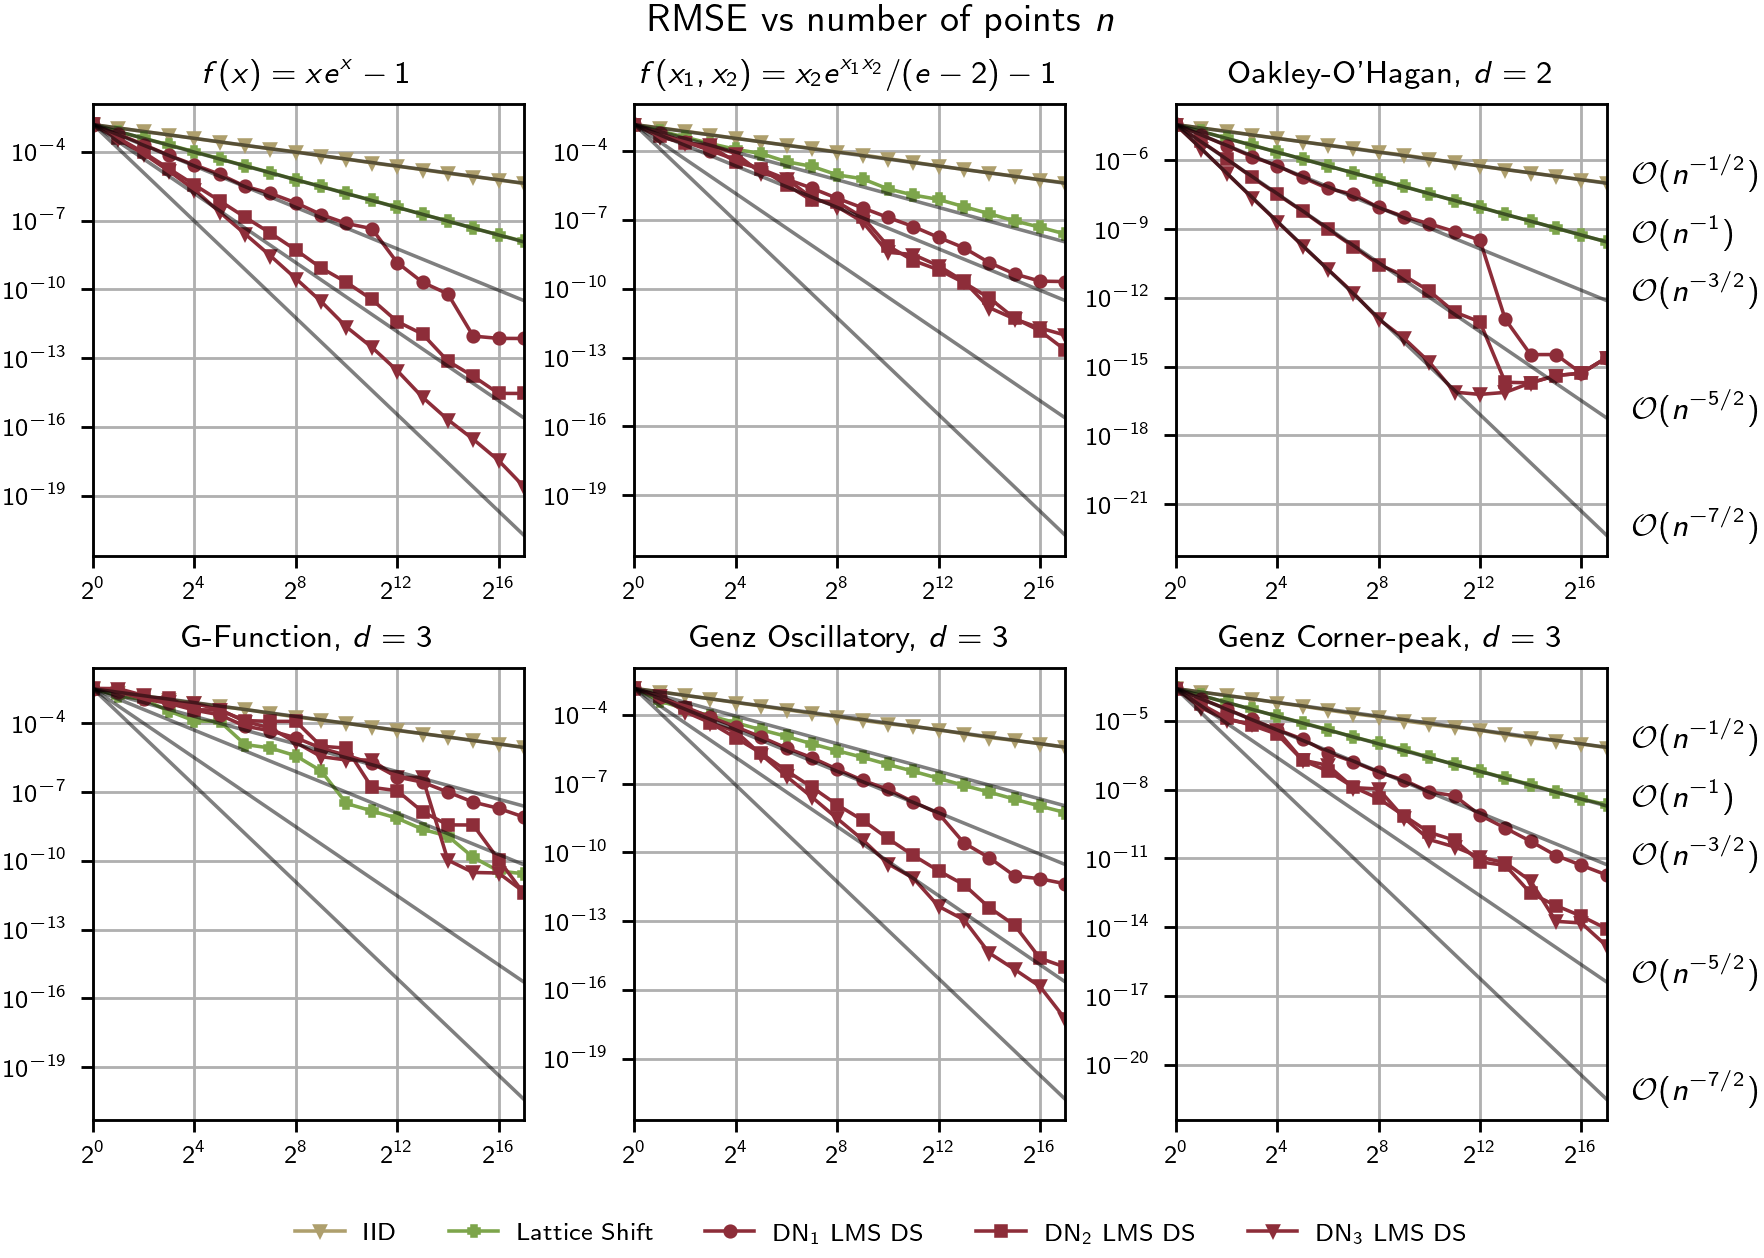

In [143]:
nrows = 2
ncols = 3 
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(MW2,MW2/ncols*nrows),sharey=False,sharex=True)
ax = np.atleast_1d(ax)
mvec = np.arange(0,m_max+1)
nvec = 2**mvec
commonkwargs = {"markersize":3,"linewidth":1}#,"markerfacecolor":'black',"markeredgecolor":'white'}
for i,name in enumerate(funcs.keys()):
    i1,i2 = i//ncols,i%ncols
    avgi = 0
    # avgi = rmse_noho[:,mvec[0]].mean()
    for j,(pname,(generator,pltkwargs)) in enumerate(pointsets.items()):
        ax[i1,i2].plot(nvec,rmses[name][pname][mvec],label=pname,**pltkwargs,**commonkwargs)
        avgi += rmses[name][pname][mvec[0]]
    avgi /= len(pointsets)
    for p,sp in zip([-1/2,-1.,-3/2,-5/2,-7/2],["-1/2","-1","-3/2","-5/2","-7/2"]):
        n0 = 2**mvec[0]
        kappa = avgi/(n0**p)
        nf = 2**mvec[-1]
        lf = kappa*nf**p
        ax[i1,i2].plot([nvec[0],nf],[kappa*n0**p,lf],marker="none",color="black",alpha=.5,**commonkwargs)
        if i2==2:
            ax[i1,i2].text(2*nf,lf,r"$\mathcal{O}(n^{%s})$"%sp)
    ax[i1,i2].set_yscale('log',base=10)
    ax[i1,i2].set_title(name)
    ax[i1,i2].grid(True) 
    ax[i1,i2].set_xlim(nvec[0],nvec[-1])
    ax[i1,i2].set_xscale('log',base=2)
    ax[i1,i2].xaxis.set_tick_params(labelleft=True)
fig.legend(*ax[0,0].get_legend_handles_labels(),frameon=False,loc="lower center",bbox_to_anchor=(.5,-.075),ncol=5)
fig.suptitle("RMSE vs number of points $n$",fontsize="large");
fig.savefig("outputs/convergence.png",format="png",dpi=1024,transparent=True)